In [8]:
import sys
import os
import random
import torch
import torch.nn.functional as F
import git
import numpy as np
from tqdm import tqdm

sys.path.append("../")

from src.models.disc_models import DiscreteDiagSheafDiffusion, DiscreteBundleSheafDiffusion, DiscreteGeneralSheafDiffusion
from src.utils.parser import get_parser
from src.utils.heterophilic import get_dataset, get_fixed_splits

In [9]:
def reset_wandb_env():
    exclude = {
        "WANDB_PROJECT",
        "WANDB_ENTITY",
        "WANDB_API_KEY",
    }
    for k, v in os.environ.items():
        if k.startswith("WANDB_") and k not in exclude:
            del os.environ[k]


def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)[data.train_mask]
    nll = F.nll_loss(out, data.y[data.train_mask])
    loss = nll
    loss.backward()

    optimizer.step()
    del out

def test(model, data):
    model.eval()
    with torch.no_grad():
        logits, accs, losses, preds = model(data.x), [], [], []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            pred = logits[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

            loss = F.nll_loss(logits[mask], data.y[mask])

            preds.append(pred.detach().cpu())
            accs.append(acc)
            losses.append(loss.detach().cpu())
        return accs, preds, losses

def run_exp(args, dataset, model_cls, fold):
    data = dataset[0]
    data = get_fixed_splits(data, args['dataset'], fold)
    data = data.to(args['device'])

    model = model_cls(data.edge_index, args)
    model = model.to(args['device'])

    sheaf_learner_params, other_params = model.grouped_parameters()
    optimizer = torch.optim.Adam([
        {'params': sheaf_learner_params, 'weight_decay': args['sheaf_decay']},
        {'params': other_params, 'weight_decay': args['weight_decay']}
    ], lr=args['lr'])

    epoch = 0
    best_val_acc = test_acc = 0
    best_val_loss = float('inf')
    val_loss_history = []
    val_acc_history = []
    best_epoch = 0
    bad_counter = 0
    
    
    total_pred = []
    for epoch in range(args['epochs']):
        train(model, optimizer, data)

        [train_acc, val_acc, tmp_test_acc], preds, [
            train_loss, val_loss, tmp_test_loss] = test(model, data)
        if fold == 0:
            res_dict = {
                f'fold{fold}_train_acc': train_acc,
                f'fold{fold}_train_loss': train_loss,
                f'fold{fold}_val_acc': val_acc,
                f'fold{fold}_val_loss': val_loss,
                f'fold{fold}_tmp_test_acc': tmp_test_acc,
                f'fold{fold}_tmp_test_loss': tmp_test_loss,
            }
            wandb.log(res_dict, step=epoch)

        new_best_trigger = val_acc > best_val_acc if args['stop_strategy'] == 'acc' else val_loss < best_val_loss
        if new_best_trigger:
            best_val_acc = val_acc
            best_val_loss = val_loss
            test_acc = tmp_test_acc
            best_epoch = epoch
            bad_counter = 0
        else:
            bad_counter += 1

        if bad_counter == args['early_stopping']:
            break
#haven't tested the following yet        
        
        if epoch % 100 == 0:
            total_pred.append(preds)
            
            

    print(f"Fold {fold} | Epochs: {epoch} | Best epoch: {best_epoch}")
    print(f"Test acc: {test_acc:.4f}")
    print(f"Best val acc: {best_val_acc:.4f}")

    if "ODE" not in args['model']:
        # Debugging for discrete models
        for i in range(len(model.sheaf_learners)):
            L_max = model.sheaf_learners[i].L.detach().max().item()
            L_min = model.sheaf_learners[i].L.detach().min().item()
            L_avg = model.sheaf_learners[i].L.detach().mean().item()
            L_abs_avg = model.sheaf_learners[i].L.detach().abs().mean().item()
            print(f"Laplacian {i}: Max: {L_max:.4f}, Min: {L_min:.4f}, Avg: {L_avg:.4f}, Abs avg: {L_abs_avg:.4f}")

        with np.printoptions(precision=3, suppress=True):
            for i in range(0, args['layers']):
                print(f"Epsilons {i}: {model.epsilons[i].detach().cpu().numpy().flatten()}")

    wandb.log({'best_test_acc': test_acc, 'best_val_acc': best_val_acc, 'best_epoch': best_epoch})
    keep_running = False if test_acc < args['min_acc'] else True

    return test_acc, best_val_acc, keep_running, total_pred


In [7]:
#first loss

# setup the parameters
parser = get_parser()
args = parser.parse_args("")

repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha

#rewrite and add some parameters
args.d = 3
args.layers = 4
args.dropout = 0.7
args.dataset = "texas"
args.model = "BundleSheaf"
args.entity = "sheafnn"

dataset = get_dataset(args.dataset)

args.graph_size = dataset[0].x.size(0)
args.input_dim = dataset.num_features
args.output_dim = dataset.num_classes
args.device = torch.device(f'cuda:{args.cuda}' if torch.cuda.is_available() else 'cpu')
assert args.normalised or args.deg_normalised
if args.sheaf_decay is None:
    args.sheaf_decay = args.weight_decay


if args.model == 'DiagSheafODE':
    model_cls = DiagSheafDiffusion
elif args.model == 'BundleSheafODE':
    model_cls = BundleSheafDiffusion
elif args.model == 'GeneralSheafODE':
    model_cls = GeneralSheafDiffusion
elif args.model == 'DiagSheaf':
    model_cls = DiscreteDiagSheafDiffusion
elif args.model == 'BundleSheaf':
    model_cls = DiscreteBundleSheafDiffusion
elif args.model == 'GeneralSheaf':
    model_cls = DiscreteGeneralSheafDiffusion
else:
    raise ValueError(f'Unknown model')


# Set the seed for everything
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

results = []

import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = 'sheafnn_notebook'
wandb.init(project="sheafnn", config=vars(args), entity=args.entity)
    
#train the diffusion process


for fold in tqdm(range(args.folds)):
        test_acc, best_val_acc, keep_running, predictions = run_exp(wandb.config, dataset, model_cls, fold)
        results.append([test_acc, best_val_acc])
        if not keep_running:
            break




 10%|█         | 1/10 [00:14<02:13, 14.80s/it]

Fold 0 | Epochs: 607 | Best epoch: 407
Test acc: 0.7838
Best val acc: 0.8136
Laplacian 0: Max: 0.0111, Min: -0.0677, Avg: -0.0205, Abs avg: 0.0218
Laplacian 1: Max: 0.0149, Min: -0.0746, Avg: -0.0206, Abs avg: 0.0236
Laplacian 2: Max: 0.0496, Min: -0.1040, Avg: -0.0221, Abs avg: 0.0294
Laplacian 3: Max: 0.0996, Min: -0.1550, Avg: -0.0297, Abs avg: 0.0442
Epsilons 0: [1.186 1.192 1.042]
Epsilons 1: [1.193 1.197 1.062]
Epsilons 2: [1.195 1.208 1.08 ]
Epsilons 3: [1.216 1.246 1.097]


 20%|██        | 2/10 [00:32<02:10, 16.34s/it]

Fold 1 | Epochs: 759 | Best epoch: 559
Test acc: 0.9189
Best val acc: 0.8136
Laplacian 0: Max: 0.0102, Min: -0.0761, Avg: -0.0239, Abs avg: 0.0255
Laplacian 1: Max: 0.0158, Min: -0.0890, Avg: -0.0270, Abs avg: 0.0287
Laplacian 2: Max: 0.0335, Min: -0.1305, Avg: -0.0314, Abs avg: 0.0356
Laplacian 3: Max: 0.1466, Min: -0.2031, Avg: -0.0320, Abs avg: 0.0427
Epsilons 0: [1.263 1.269 1.218]
Epsilons 1: [1.276 1.281 1.229]
Epsilons 2: [1.294 1.298 1.25 ]
Epsilons 3: [1.288 1.288 1.277]


 30%|███       | 3/10 [00:45<01:44, 14.88s/it]

Fold 2 | Epochs: 575 | Best epoch: 375
Test acc: 0.8378
Best val acc: 0.8814
Laplacian 0: Max: 0.0251, Min: -0.0722, Avg: -0.0222, Abs avg: 0.0252
Laplacian 1: Max: 0.0339, Min: -0.0975, Avg: -0.0264, Abs avg: 0.0313
Laplacian 2: Max: 0.1565, Min: -0.2032, Avg: -0.0273, Abs avg: 0.0480
Laplacian 3: Max: 0.2799, Min: -0.5277, Avg: -0.0553, Abs avg: 0.0908
Epsilons 0: [1.102 1.214 1.091]
Epsilons 1: [1.121 1.202 1.096]
Epsilons 2: [1.117 1.215 1.099]
Epsilons 3: [1.122 1.217 1.108]


 40%|████      | 4/10 [00:51<01:09, 11.53s/it]

Fold 3 | Epochs: 278 | Best epoch: 78
Test acc: 0.8378
Best val acc: 0.8305
Laplacian 0: Max: 0.0436, Min: -0.0924, Avg: -0.0255, Abs avg: 0.0333
Laplacian 1: Max: 0.0733, Min: -0.0802, Avg: -0.0157, Abs avg: 0.0283
Laplacian 2: Max: 0.1078, Min: -0.1016, Avg: -0.0114, Abs avg: 0.0273
Laplacian 3: Max: 0.1819, Min: -0.1844, Avg: -0.0248, Abs avg: 0.0578
Epsilons 0: [1.116 0.873 0.963]
Epsilons 1: [1.124 0.842 0.934]
Epsilons 2: [1.113 0.889 0.966]
Epsilons 3: [1.112 0.931 0.964]


 50%|█████     | 5/10 [00:59<00:51, 10.31s/it]

Fold 4 | Epochs: 357 | Best epoch: 157
Test acc: 0.8108
Best val acc: 0.9492
Laplacian 0: Max: 0.0477, Min: -0.0902, Avg: -0.0247, Abs avg: 0.0300
Laplacian 1: Max: 0.0580, Min: -0.1224, Avg: -0.0270, Abs avg: 0.0382
Laplacian 2: Max: 0.2102, Min: -0.3188, Avg: -0.0223, Abs avg: 0.0667
Laplacian 3: Max: 0.4530, Min: -0.4419, Avg: 0.0160, Abs avg: 0.0701
Epsilons 0: [1.052 1.089 1.088]
Epsilons 1: [1.034 1.099 1.101]
Epsilons 2: [1.035 1.132 1.11 ]
Epsilons 3: [1.028 1.116 1.092]


 60%|██████    | 6/10 [01:08<00:38,  9.64s/it]

Fold 5 | Epochs: 369 | Best epoch: 169
Test acc: 0.8919
Best val acc: 0.9153
Laplacian 0: Max: 0.0351, Min: -0.0902, Avg: -0.0236, Abs avg: 0.0276
Laplacian 1: Max: 0.0334, Min: -0.0947, Avg: -0.0201, Abs avg: 0.0252
Laplacian 2: Max: 0.0683, Min: -0.1080, Avg: -0.0130, Abs avg: 0.0274
Laplacian 3: Max: 0.1047, Min: -0.1173, Avg: -0.0103, Abs avg: 0.0249
Epsilons 0: [1.086 1.019 1.059]
Epsilons 1: [1.105 1.028 1.087]
Epsilons 2: [1.125 1.011 1.092]
Epsilons 3: [1.115 1.055 1.104]


 70%|███████   | 7/10 [01:15<00:26,  8.77s/it]

Fold 6 | Epochs: 306 | Best epoch: 106
Test acc: 0.9189
Best val acc: 0.8305
Laplacian 0: Max: 0.0259, Min: -0.0843, Avg: -0.0230, Abs avg: 0.0268
Laplacian 1: Max: 0.0388, Min: -0.0796, Avg: -0.0198, Abs avg: 0.0263
Laplacian 2: Max: 0.0893, Min: -0.1383, Avg: -0.0320, Abs avg: 0.0476
Laplacian 3: Max: 0.6893, Min: -0.8508, Avg: -0.0670, Abs avg: 0.1751
Epsilons 0: [0.963 1.    0.954]
Epsilons 1: [0.968 1.003 1.005]
Epsilons 2: [1.055 1.042 1.018]
Epsilons 3: [1.038 1.032 1.052]


 80%|████████  | 8/10 [01:20<00:15,  7.74s/it]

Fold 7 | Epochs: 236 | Best epoch: 36
Test acc: 0.7297
Best val acc: 0.7966
Laplacian 0: Max: 0.0616, Min: -0.1023, Avg: -0.0198, Abs avg: 0.0289
Laplacian 1: Max: 0.0377, Min: -0.0601, Avg: -0.0135, Abs avg: 0.0207
Laplacian 2: Max: 0.1350, Min: -0.1379, Avg: -0.0279, Abs avg: 0.0485
Laplacian 3: Max: 0.1144, Min: -0.1324, Avg: -0.0070, Abs avg: 0.0257
Epsilons 0: [0.907 0.905 0.811]
Epsilons 1: [0.925 0.886 0.85 ]
Epsilons 2: [0.899 0.887 0.859]
Epsilons 3: [0.936 0.933 0.895]


 90%|█████████ | 9/10 [01:36<00:10, 10.31s/it]

Fold 8 | Epochs: 710 | Best epoch: 510
Test acc: 0.7838
Best val acc: 0.9322
Laplacian 0: Max: 0.0235, Min: -0.0739, Avg: -0.0223, Abs avg: 0.0250
Laplacian 1: Max: 0.0320, Min: -0.0791, Avg: -0.0235, Abs avg: 0.0281
Laplacian 2: Max: 0.0506, Min: -0.0891, Avg: -0.0193, Abs avg: 0.0294
Laplacian 3: Max: 0.1273, Min: -0.1520, Avg: -0.0126, Abs avg: 0.0373
Epsilons 0: [1.207 1.276 1.253]
Epsilons 1: [1.221 1.292 1.259]
Epsilons 2: [1.207 1.318 1.238]
Epsilons 3: [1.274 1.335 1.267]


100%|██████████| 10/10 [01:46<00:00, 10.69s/it]

Fold 9 | Epochs: 437 | Best epoch: 237
Test acc: 0.8108
Best val acc: 0.8136
Laplacian 0: Max: 0.0144, Min: -0.0871, Avg: -0.0232, Abs avg: 0.0257
Laplacian 1: Max: 0.0216, Min: -0.1036, Avg: -0.0193, Abs avg: 0.0229
Laplacian 2: Max: 0.0624, Min: -0.0875, Avg: -0.0135, Abs avg: 0.0272
Laplacian 3: Max: 0.0964, Min: -0.1046, Avg: -0.0073, Abs avg: 0.0244
Epsilons 0: [1.113 1.018 1.055]
Epsilons 1: [1.12  1.042 1.084]
Epsilons 2: [1.142 1.04  1.1  ]
Epsilons 3: [1.147 1.06  1.105]


In [4]:
test_acc_mean, val_acc_mean = np.mean(results, axis=0) * 100
test_acc_std = np.sqrt(np.var(results, axis=0)[0]) * 100

wandb_results = {'test_acc': test_acc_mean, 'val_acc': val_acc_mean, 'test_acc_std': test_acc_std}
wandb.log(wandb_results)
wandb.finish()


best_epoch,▂▃█▂▂▄▁▁▇█
best_test_acc,▂█▃▄▄▇▄▁▂█
best_val_acc,▁▂▄▄█▇▄▄▇▃
fold0_tmp_test_acc,▁▂▂▂▄▇█▇▇█▇▆▇▆██▇▇▇███▇▇▆▇▇▇▇█▆▇▇▇▇▇▇█▇█
fold0_tmp_test_loss,█▆▄▄▃▂▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▃▃▃▅▄▃▃▃▃▄▃▄
fold0_train_acc,▁▁▁▄▄▇██████████████████████████████████
fold0_train_loss,█▇▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
fold0_val_acc,▁▁▁▂▂▅▇▇▇▇▆▇▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇
fold0_val_loss,█▇▆▅▄▃▂▁▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▂▂▂▁▂▂▁▂▂▂▂▁▁▂▂▂▂
test_acc,▁
test_acc_std,▁


In [5]:
model_name = args.model if args.evectors == 0 else f"{args.model}+LP{args.evectors}"
print(f'{model_name} on {args.dataset} | SHA: {sha}')
print(f'Test acc: {test_acc_mean:.4f} +/- {test_acc_std:.4f} | Val acc: {val_acc_mean:.4f}')


BundleSheaf on texas | SHA: 6a21326cef112232a48ac2a9825d72c459766fc8
Test acc: 83.7838 +/- 5.4054 | Val acc: 86.1017


In [10]:
predictions

[[tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
  tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
  tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])],
 [tensor([3, 4, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 0, 2, 3, 3, 3, 4, 3,
          3, 2, 0, 3, 2, 4, 4, 3, 3, 3, 3, 0, 3, 4, 3, 2, 2, 4, 3, 0, 3, 3, 3, 0,
          4, 3, 0, 4, 2, 3, 3, 3, 0, 0, 3, 3, 3, 0, 4, 2, 3, 4, 4, 3, 3, 3, 3, 3,
          3, 3, 0, 3, 3, 0, 0, 3, 3, 0, 3, 0, 4, 3, 3]),
  tensor([0, 3, 3, 0, 3, 0, 3, 3, 4, 2, 0, 0, 3, 3,

In [22]:
get_fixed_splits(dataset[0], "texas", 1).edge_index

tensor([[  0,   0,   1,  ..., 180, 181, 182],
        [ 58, 121,  80,  ...,  84,  56,  29]])

In [23]:
data =dataset[0] 

threshold 0.07692307692307693


/home/mila/y/yanlei.zhang/.conda/envs/sheafnn/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


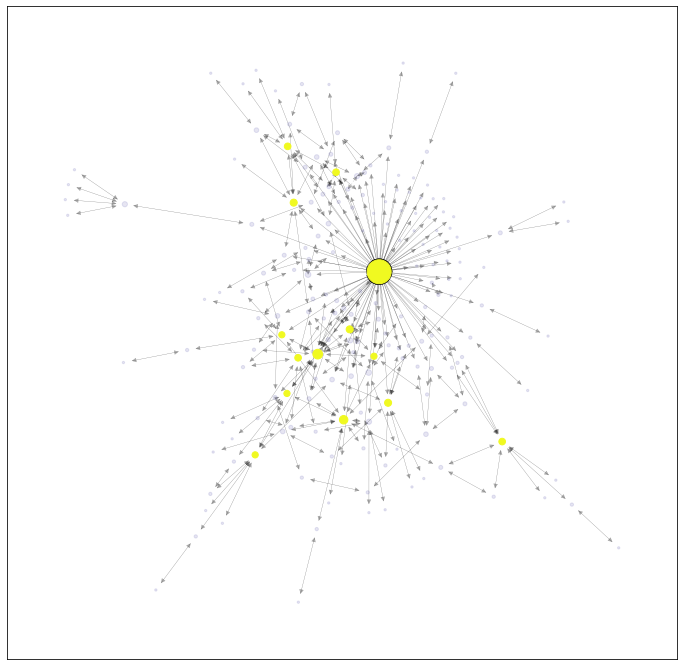

In [27]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=False)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()


In [28]:
label_dict = {
    0: "student",
    1: "project",
    2: "course",
    3: "staff",
    4: "faculty"}
    
data.y[:10]

tensor([3, 0, 2, 3, 4, 3, 0, 0, 3, 0])

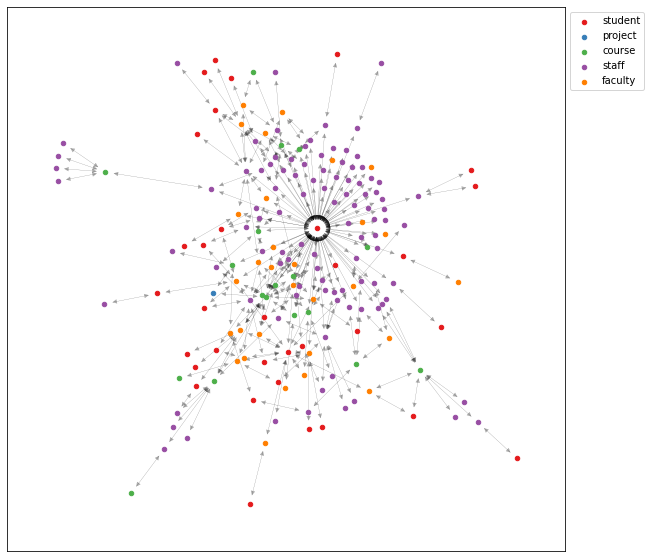

In [30]:

G = to_networkx(data, to_undirected=False)
node_color = []
nodelist = [[], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 20, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.2, alpha = 0.3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig("texas.png", dpi = 150, bbox_inches="tight")